In [3]:
import pandas as pd
import sklearn.metrics

pd.options.mode.chained_assignment = None
import numpy as np
from tqdm import tqdm

import xgboost as xgb

import optuna
from optuna.samplers import RandomSampler, TPESampler
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, log_loss, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

import os

from training import (
    plot_auc_roc, plot_recision_recall_f1, 
    plot_countbar, plot_line,
    plot_diff_in_means, plot_cross_tab_heatmap, 
    plot_predictions_by_scores,
    model_training
)

from datetime import datetime
import logging
NOW = datetime.today().isoformat()[:19]
logging.basicConfig(
    filemode='a',
    filename=f'./logs/{NOW}_outputlog.log',
    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
    datefmt='%H:%M:%S',
    level=logging.INFO
)

logger = logging.getLogger(__name__)
logger.info("++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [2]:
# to get the cleaned data from directory
list_of_file_names = []
for file in os.listdir('data_full_review_cleaned/'):
   if file.endswith(".json"):
      list_of_file_names.append(os.path.join(file))

In [ ]:
# preparing the dataframe for foundations
list_of_foundations = pd.read_csv('foundation_from_sephora_with_url.csv')
list_of_foundations['model'] = None
## placeholder for path to trained models
list_of_foundations['threshold'] = float()
## placeholder for best threshold
list_of_foundations['auc'] = float()
## placeholder for performance metrics (ROC-AUC) for each of the models
list_of_foundations.head()

In [ ]:
# training models
for i in range(len(list_of_file_names)):
    product = model_training(file_name = list_of_file_names[i], random_seeds = 0, logger = logger)
    if len(product.data) <= 200:
        logger.info(f'N = {len(product.data)} (<= 200), dropped for training')
        continue
    product.train_test_split()
    product.dropping_outlier_reviewers()
    product.feature_engineering() # one-hot encoding and feature crossing

    product.grid_search()
    product.train_xgb_classifier()
    product.thresholding()

    index = list_of_foundations.index[list_of_foundations['brand_product'] == product.product_name].tolist()[0]
    list_of_foundations.loc[index, 'model'] = f'{product.product_name}_xgb.model'
    list_of_foundations.loc[index, 'threshold'] = product.best_threshold
    list_of_foundations.loc[index, 'auc'] = roc_auc_score(product.val_y, product.predict_y)

    product.plot_predictions_by_scores(val_y = product.val_y, product=product.product_name, model = 'xgb')
    product.plot_precision_recall_f1(val_y=product.val_y, product=product.product_name, model='xgb')
    product.plot_auc_roc(val_y=product.val_y, product=product.product_name, model = 'xgb')

In [19]:
list_of_foundations.to_json("list_of_foundations_with_models.json", orient="records", lines=True)

In [3]:
## saving one-hot encoder
for i in tqdm(range(len(list_of_file_names))):
    product = model_training(file_name = list_of_file_names[i], random_seeds = 0, logger = logger)
    if len(product.data) <= 200:
        logger.info(f'N = {len(product.data)} (<= 200), dropped for training')
        continue
    product.train_test_split()
    product.dropping_outlier_reviewers()
    product.feature_engineering()

100%|██████████| 102/102 [00:04<00:00, 23.63it/s]


In [4]:
len(list_of_file_names)

102

In [30]:
file_name = "tarte_Amazonian_Clay_BB_Tinted_Moisturizer_Broad_Spectrum_SPF_20_Sunscreen.json"
product = model_training(file_name=file_name, random_seeds=0, logger=logger)
product.train_test_split()
product.dropping_outlier_reviewers()
product.feature_engineering()

In [31]:
product.skin_tone_one_hot_train.columns

Index(['Fair', 'Light', 'Medium', 'Olive', 'Porcelain'], dtype='object')

In [4]:
import pickle
with open('models/CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15/col_names_CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15_skin_tone.pickle', 'rb') as f:
    col_names_dicts = pickle.load(f)

In [5]:
col_names_dicts

{0: 'Dark', 1: 'Deep', 2: 'Fair', 3: 'Light', 4: 'Medium', 5: 'Olive'}

In [6]:
with open('models/CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15/encoder_CLINIQUE_Even_Better_Foundation_Makeup_Broad_Spectrum_SPF_15_skin_tone.pickle', 'rb') as f:
    encoder = pickle.load(f)

In [7]:
encoder.transform(product.val_X[['skin_tone']])

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0.

In [8]:
product.val_X[product.val_X['skin_tone']=='Olive']

,hair_color,eye_color,skin_tone,skin_type,skin_tone_cat,finish,coverage,shade_match,gifted,days_since_launch_scaled,month_of_purchase


In [20]:
test_input = pd.read_json("data_full_review_cleaned/Anastasia_Beverly_Hills_Stick_Foundation.json", lines=True)
test_input = test_input.loc[0]
test_input = test_input[[
    "eye_color", "hair_color", "skin_type", "skin_tone", "finish", "coverage", "shade_match", "gifted",
    "days_since_launch_scaled", "month_of_purchase", "skin_tone_cat"
]]
test_input = test_input.to_dict()
test_input = pd.DataFrame([test_input])

In [23]:
encoder.transform(test_input[['skin_tone']])

array([[0., 0., 0., 0., 0., 0.]])

In [21]:
test_input['skin_tone']

0    Olive
Name: skin_tone, dtype: object

In [21]:
type(product.val_X[['skin_tone']])

pandas.core.frame.DataFrame

In [4]:
all_models = pd.read_json("list_of_foundations_with_models.json", lines=True)
all_models = all_models[all_models['model'].notna()]

<AxesSubplot:>

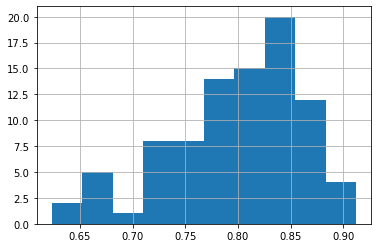

In [5]:
all_models['auc'].hist()

In [45]:
all_models['auc'].mean()

0.7982903452011236

In [47]:
all_models['auc'].describe()

count    89.000000
mean      0.798290
std       0.063927
min       0.623377
25%       0.763107
50%       0.812798
75%       0.845636
max       0.912037
Name: auc, dtype: float64

In [48]:
all_models[all_models['auc']>=0.91]

,Unnamed: 0,brand_product,url,url_valid,model,threshold,auc
87,87,IT_Cosmetics_Your_Skin_But_Better_Foundation_+...,https://www.sephora.com/product/it-cosmetics-y...,1,IT_Cosmetics_Your_Skin_But_Better_Foundation_+...,0.29,0.912037


In [10]:
all_models[all_models['auc'] >= 0.80].sort_values(by='auc', ascending=True)

,Unnamed: 0,brand_product,url,url_valid,model,threshold,auc
64,64,FENTY_BEAUTY_by_Rihanna_Pro_Filt'r_Hydrating_L...,https://www.sephora.com/product/pro-filt-r-hyd...,1,FENTY_BEAUTY_by_Rihanna_Pro_Filt'r_Hydrating_L...,0.35,0.800127
149,149,SEPHORA_COLLECTION_Matte_Perfection_Tinted_Moi...,https://www.sephora.com/product/matte-perfecti...,1,SEPHORA_COLLECTION_Matte_Perfection_Tinted_Moi...,0.50,0.800140
174,174,Yves_Saint_Laurent_Touche_Eclat_All-In-One_Glo...,https://www.sephora.com/product/touche-eclat-a...,1,Yves_Saint_Laurent_Touche_Eclat_All-In-One_Glo...,0.53,0.804746
78,78,Hourglass_Vanish™_Seamless_Finish_Liquid_Found...,https://www.sephora.com/product/vanish-seamles...,1,Hourglass_Vanish™_Seamless_Finish_Liquid_Found...,0.43,0.805046
128,128,NARS_Natural_Radiant_Longwear_Foundation,https://www.sephora.com/product/natural-radian...,1,NARS_Natural_Radiant_Longwear_Foundation_xgb.m...,0.68,0.809336
158,158,Smashbox_Studio_Skin_24_Hour_Oil-Free_Hydra_Fo...,https://www.sephora.com/product/studio-skin-15...,1,Smashbox_Studio_Skin_24_Hour_Oil-Free_Hydra_Fo...,0.31,0.812798
114,114,Laura_Mercier_Tinted_Moisturizer_Broad_Spectru...,https://www.sephora.com/product/tinted-moistur...,1,Laura_Mercier_Tinted_Moisturizer_Broad_Spectru...,0.59,0.813100
100,100,Kosas_Tinted_Face_Oil_Foundation,https://www.sephora.com/product/tinted-face-oi...,1,Kosas_Tinted_Face_Oil_Foundation_xgb.model,0.42,0.814930
118,118,MAKE_UP_FOR_EVER_Reboot_Active_Care_Revitalizi...,https://www.sephora.com/product/make-up-for-ev...,1,MAKE_UP_FOR_EVER_Reboot_Active_Care_Revitalizi...,0.39,0.815753
80,80,ILIA_Super_Serum_Skin_Tint_SPF_40_Foundation,https://www.sephora.com/product/ilia-super-ser...,1,ILIA_Super_Serum_Skin_Tint_SPF_40_Foundation_x...,0.62,0.818822


### Training models with additional features from preference for coverage and finish

In [ ]:
foundation_data = pd.read_json('data_full_review_cleaned/0_foundation_data_all_cleaned.json', lines=True)